In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.exposure import equalize_adapthist
from skimage import img_as_float, img_as_ubyte

#from moviepy.editor import *
from moviepy.editor import VideoFileClip

import os

In [2]:
class SmartFigure:
    def __init__(self, rows = 1, cols = 1, size = (16,8)):
        f, arr = plt.subplots(rows, cols, figsize=size)
        
        f.tight_layout()
        
        self.f = f
        self.arr = arr
        self.rows = rows
        self.cols = cols
        self.row_index = 0
        self.col_index = 0
        
    @property
    def ax(self):
        if self.rows == 1:
            return self.arr[self.col_index]
        else:
            return self.arr[self.row_index][self.col_index]
        
    def increment(self):
        if self.col_index == self.cols-1:
            self.row_index +=1
            self.col_index = 0
        else:
            self.col_index += 1
        
    def show_color(self, img, title = None):
        if title != None:
            self.ax.set_title(title, fontsize=16)
            
        self.ax.imshow(img)
        
        self.increment()
    
    def show_gray(self, img, title = None):
        if title != None:
            self.ax.set_title(title, fontsize=16)
            
        self.ax.imshow(img, cmap='gray')
        
        self.increment()

In [3]:
def get_test_images():
    return glob.glob('./test_images/*.jpg')

def get_project_images():
    return sorted(glob.glob('./challenge_video_img/*.png'), key=os.path.getmtime)

def get_challange_images():
    return sorted(glob.glob('./challenge_video_img/*.png'), key=os.path.getmtime)

def get_hard_images():
    return sorted(glob.glob('./challenge_video_img/*.png'), key=os.path.getmtime)

## Camera Calibration

In [4]:
def calibrate_camera():

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        print(fname)
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
        nx = 9
        ny = 6
    
        if fname in ['./camera_cal\calibration1.jpg']:
            ny = 5
        
            objp = np.zeros((nx*ny,3), np.float32)
            objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
        
        elif fname in ['./camera_cal\calibration5.jpg']:
            ny = 6
            nx = 7
        
            objp = np.zeros((nx*ny,3), np.float32)
            objp[:,:2] = np.mgrid[2:9,0:ny].T.reshape(-1,2)
        
        elif fname in ['./camera_cal\calibration4.jpg']:
            nx = 7
            ny = 4
        
            objp = np.zeros((nx*ny,3), np.float32)
            objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
        
        else:
            objp = np.zeros((nx*ny,3), np.float32)
            objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
                

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            #plt.imshow(img)
            #plt.show()
        else:
            print("fail")
            print(ret)
            print(corners)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (1280,720), None, None)

    return mtx, dist

In [5]:
mtx, dist = calibrate_camera()

print('Computaiton of calibration data complete.')

./camera_cal\calibration1.jpg
./camera_cal\calibration10.jpg
./camera_cal\calibration11.jpg
./camera_cal\calibration12.jpg
./camera_cal\calibration13.jpg
./camera_cal\calibration14.jpg
./camera_cal\calibration15.jpg
./camera_cal\calibration16.jpg
./camera_cal\calibration17.jpg
./camera_cal\calibration18.jpg
./camera_cal\calibration19.jpg
./camera_cal\calibration2.jpg
./camera_cal\calibration20.jpg
./camera_cal\calibration3.jpg
./camera_cal\calibration4.jpg
./camera_cal\calibration5.jpg
./camera_cal\calibration6.jpg
./camera_cal\calibration7.jpg
./camera_cal\calibration8.jpg
./camera_cal\calibration9.jpg
Computaiton of calibration data complete.


## Image transformation helpers

In [6]:
# Load image from file
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

# Undistort image using calibration data
def undistort_image(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [7]:
# Get coordinates for perspective transformation
def get_src_dst(img_size):
    src = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
    #src = np.float32([[490, 482],[810, 482],[1280, 736],[9, 736]])
    #src = np.float32([[530, 460],[770, 460],[1280, 736],[9, 736]])
    #src = np.float32([
    #                             [568,470],
    #                             [717,470],
    #                             [1043,680], [260,680]])
    dst = np.float32([[0,0],[img_size[1],0],[img_size[1],img_size[0]],[0,img_size[0]]])
    
    return src, dst

# Get transform for perspective transformation camera->birdseye
def get_warp_transform(img_size):
    src, dst = get_src_dst(img_size)
        
    M = cv2.getPerspectiveTransform(src, dst)
        
    return M

# Get transform for perspective transformation birdseye->camera
def get_unwarp_transform(img_size):
    src, dst = get_src_dst(img_size)
        
    M = cv2.getPerspectiveTransform(dst, src)
        
    return M

# Apply perspective transformation camera->birdseye
def warp_image(img, draw_polygon=False):
    img_size = np.array(img).shape[0:2]
    
    M = get_warp_transform(img_size)
        
    warped = cv2.warpPerspective(img, M, img_size[::-1])
    
    if draw_polygon:
        cv2.polylines(img, [np.array(src, np.int32)], True, (0,0,255), 3)
    
    return warped
    
# Apply perspective transformation birdseye->camera
def unwarp_image(img):
    img_size = np.array(img).shape[0:2]
    
    M = get_unwarp_transform(img_size)
        
    return cv2.warpPerspective(img, M, img_size[::-1])

# Apply local image histogram equalization
def equalize_image(img):
    return img_as_ubyte(equalize_adapthist(img_as_float(img)))

### Demo of undistortion

In [ ]:
def load_undistort_transform_show():
    images = get_test_images()
    
    for fname in images:
        img = load_image(fname)
        
        undist = undistort_image(img)
        
        transformed = warp_image(undist)
        
        #equalize = equalize_image(transformed)
        
        f = SmartFigure(1, 3, size=(16,8))
        
        f.show_color(img)
        f.show_color(undist)
        f.show_color(transformed)
        #f.show_color(equalize)
        
        plt.show()

In [ ]:
load_undistort_transform_show()

## Color and Gradient Masks

In [8]:
def mask_color(img, space_transform, channel, threshold=(0,255)):
    data = cv2.cvtColor(img, space_transform)[:,:,channel]
    
    binary = np.zeros_like(data)
    binary[(data >= threshold[0]) & (data <= threshold[1])] = 1
    
    return binary

In [9]:
def dir_sobel(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.abs(sobel_x)
    abs_sobel_y = np.abs(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir = np.arctan2(abs_sobel_y, abs_sobel_x)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(dir)
    mask[(dir > thresh[0]) & (dir < thresh[1])] = 1
    
    return mask

In [10]:
def mag_sobel(img, sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = img #cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    abs_sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    factor = np.max(abs_sobel)/255
    scaled_sobel = np.uint8(abs_sobel/factor)
    # 5) Create a binary mask where mag thresholds are met
    mask = np.zeros_like(scaled_sobel)
    mask[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mask

In [11]:
def transformed_to_binary(img):
    pip2 = mask_color(img, cv2.COLOR_RGB2LUV, 0, (220, 255))
    pip3 = mask_color(img, cv2.COLOR_RGB2Lab, 2, (150, 200))
        
    combined = np.zeros_like(pip2)
    combined[(pip2 == 1) | (pip3 == 1)] = 1
        
    return combined

### Demo of Masks

In [ ]:
def load_undistort_transform_pipeline_show():
    images = get_test_images()
    
    for fname in images:
        img = load_image(fname)
        
        undist = undistort_image(img)
        
        transformed = warp_image(undist)
        
        equalize = equalize_image(transformed)
        
        pip1 = mask_color(equalize, cv2.COLOR_RGB2HLS, 2, (180, 255))
        pip2 = mask_color(equalize, cv2.COLOR_RGB2LUV, 0, (200, 255))
        pip3 = mask_color(equalize, cv2.COLOR_RGB2Lab, 2, (150, 200))
        
        combined = transformed_to_binary(equalize)
        
        pip2x = mask_color(transformed, cv2.COLOR_RGB2LUV, 0, (200, 255))
        pip3x = mask_color(transformed, cv2.COLOR_RGB2Lab, 2, (150, 200))
        
        
        combinedx = transformed_to_binary(transformed)
        
        #sob1 = mag_sobel(combined, sobel_kernel=3, thresh=(30, 100))
        #sob2 = mag_sobel(combined, sobel_kernel=5, thresh=(30, 100))
        #sob3 = mag_sobel(combined, sobel_kernel=15, thresh=(30, 100))
        #sob4 = mag_sobel(combined, sobel_kernel=3, thresh=(50, 100))
        #sob5 = mag_sobel(combined, sobel_kernel=5, thresh=(50, 100))
        #sob6 = mag_sobel(combined, sobel_kernel=15, thresh=(50, 100))
        
        sob1 = dir_sobel(combined, sobel_kernel=3, thresh=(0.7,1.3))
        sob2 = dir_sobel(combined, sobel_kernel=5, thresh=(0.7,1.3))
        sob3 = dir_sobel(combined, sobel_kernel=15, thresh=(0.7,1.3))
        sob4 = dir_sobel(combined, sobel_kernel=3, thresh=(0.8,1.2))
        sob5 = dir_sobel(combined, sobel_kernel=3, thresh=(0.9,1.1))
        sob6 = dir_sobel(combined, sobel_kernel=3, thresh=(0.7,1.3))
        
        
        
        #sob1 = dir_sobel(equalize, sobel_kernel=3, thresh=(0.7,1.3))
        #sob2 = mag_sobel(equalize, sobel_kernel=5, thresh=(30, 100))
        #sob6 = np.zeros_like(sob2)
        #sob6[(sob3 == 1) & (combined == 1)] = 1
        
        f = SmartFigure(4, 3)
        
        f.show_color(undist)
        f.show_color(transformed)
        f.show_gray(equalize)
        #f.show_gray(pip2x)
        #f.show_gray(pip3x)
        #f.show_gray(combinedx)
        f.show_gray(pip2)
        f.show_gray(pip3)
        f.show_gray(combined)
        f.show_gray(cv2.cvtColor(combined, cv2.COLOR_GRAY2RGB))
        #f.show_gray(sob1)
        #f.show_gray(sob2)
        #f.show_gray(sob3)
        #f.show_gray(sob4)
        #f.show_gray(sob5)
        #f.show_gray(sob6)
        
        
        plt.show()

In [ ]:
load_undistort_transform_pipeline_show()

## Lane Tracking

In [41]:
def get_window_base(binary):
    img_size = binary.shape[0:2]
    offsety = int(img_size[0]/2)
    histogram = np.sum(binary[offsety:,:], axis=0)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return leftx_base, rightx_base

def curvature_from_poly(poly, y):
    curvature = ((1 + (2*poly[0]*y + poly[1])**2)**1.5) / np.absolute(2*poly[0])
    #print(curvature)
    return curvature

def exp_smooth(current_value, next_value, alpha = 0.3):
    if current_value is not None:
        return alpha * next_value + (1.-alpha) * current_value
    else:
        return next_value

class Lane:
    def __init__(self):
        self.initialized = False
        
        self.img_width = 1280
        self.img_height = 720
        
        self.leftx_base = None
        self.lefty_base = None
        
        # Polynomial coefficients
        self.current_left_fit = None
        self.current_right_fit = None
        
        self.best_left_fit = None
        self.best_right_fit = None
        
        self.current_left_fit_cr = None
        self.current_right_fit_cr = None
        
        self.best_left_fit_cr = None
        self.best_right_fit_cr = None
        
        self.left_curverad = 0
        self.right_curverad = 0
        
        # Found lane pixels left
        self.leftx = []
        self.lefty = []
        
        # Found lane pixels right
        self.rightx = []
        self.righty = []
        
        self.ploty = np.linspace(0, self.img_height-1, self.img_height )
        
        # Approximation left
        self.left_fitx = []
        
        # Approximation right
        self.right_fitx = []
        
        self.skipped_left = 0
        self.skipped_right = 0
        
    def draw_window_search(self):
        out_img = np.zeros((self.img_height,self.img_width,3), dtype=np.uint8)
        
        for i in range(len(self.win_xleft_lows)):
            if self.left_window_founds[i]:
                left_color = (0,255,0)
            else:
                left_color = (255,0,0)
                
            if self.right_window_founds[i]:
                right_color = (0,255,255)
            else:
                right_color = (255,0,10)
            
            cv2.rectangle(out_img,(self.win_xleft_lows[i],self.win_y_lows[i]),(self.win_xleft_highs[i],self.win_y_highs[i]),
            left_color, 5) 
            cv2.rectangle(out_img,(self.win_xright_lows[i],self.win_y_lows[i]),(self.win_xright_highs[i],self.win_y_highs[i]),
            right_color, 5)
        
        if self.best_left_fit is not None:
            out_img[self.lefty, self.leftx] = [255, 0, 0]
            
        if self.best_right_fit is not None:
            out_img[self.righty, self.rightx] = [0, 0, 255]
        
        return out_img
    
    def draw_lane(self):
        out_img = np.zeros((self.img_height,self.img_width,3), dtype=np.uint8)
    
        left_lane = len(self.left_fitx) > 0
        right_lane = len(self.right_fitx) > 0
        
        if left_lane:
            pts_left = np.array([np.flipud(np.transpose(np.vstack([self.left_fitx, self.ploty])))])
            cv2.polylines(out_img, np.int_([pts_left]), isClosed=False, color=(0,0,255), thickness = 40)
            
        if right_lane:
            pts_right = np.array([np.transpose(np.vstack([self.right_fitx, self.ploty]))])
            cv2.polylines(out_img, np.int_([pts_right]), isClosed=False, color=(255,0,0), thickness = 40)
    
        if left_lane and right_lane:
            for i in range(len(self.ploty)):
                pts = [[self.left_fitx[i], self.ploty[i]], [self.right_fitx[i], self.ploty[i]]]
        
                cv2.polylines(out_img, np.int_([pts]), isClosed=False, color=(0,255,0), thickness = 1)
        
        return out_img
    
    def update_curvature(self, min_curvature = 500):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        y_eval = np.max(self.ploty)
        
        update_left = False
        update_right = False
        
        if len(self.leftx) > 0:
            # Fit new polynomials to x,y in world space
            self.current_left_fit_cr = np.polyfit(self.lefty*ym_per_pix, self.leftx*xm_per_pix, 2)
            
            curvature = curvature_from_poly(self.current_left_fit_cr, y_eval*ym_per_pix)
            
            if curvature > min_curvature:
                self.best_left_fit_cr = exp_smooth(self.best_left_fit_cr, self.current_left_fit_cr)
                update_left = True
            
                self.left_curverad = curvature_from_poly(self.best_left_fit_cr, y_eval*ym_per_pix)
            
        if len(self.rightx) > 0:
            self.current_right_fit_cr = np.polyfit(self.righty*ym_per_pix, self.rightx*xm_per_pix, 2)
            
            curvature = curvature_from_poly(self.current_right_fit_cr, y_eval*ym_per_pix)
            
            if curvature > min_curvature:
                self.best_right_fit_cr = exp_smooth(self.best_right_fit_cr, self.current_right_fit_cr)
                update_right = True
            
                self.right_curverad = curvature_from_poly(self.best_right_fit_cr, y_eval*ym_per_pix)
            
        return update_left, update_right
    
    def draw_curvature(self, img):
        cv2.putText(img, 'Radius of left curvature {}(m)'.format(int(self.left_curverad)), (120,60),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
        cv2.putText(img, 'Radius of right curvature {}(m)'.format(int(self.right_curverad)), (120,650),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
        
        
    def update_polynom(self, binary, nwindows = 9):
        img_size = binary.shape[0:2]
        
        if not self.initialized:
            self.leftx_base, self.rightx_base = get_window_base(binary)
            
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
    
        # Set height of windows
        window_height = np.int(img_size[0]/nwindows)
    
        # Current positions to be updated for each window
        leftx_current = self.leftx_base
        rightx_current = self.rightx_base
    
        #print(leftx_current, rightx_current)
    
        # Set the width of the windows +/- margin
        margin = 120
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        self.win_xleft_lows = []
        self.win_xleft_highs = []
        self.win_xright_lows = []
        self.win_xright_highs = []
        self.win_y_lows = []
        self.win_y_highs = []
        self.left_window_founds = []
        self.right_window_founds = []
    
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img_size[0] - (window+1)*window_height
            win_y_high = img_size[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
        
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            next_top = win_y_high - window_height
            next_bottom = win_y_high
            #print(next_top, next_bottom, self.lefty)
            ind = (self.ploty >= next_top) & (self.ploty <= next_bottom)
            #print(np.any(ind), ":", ind)
            
            left_found = len(good_left_inds) > minpix
            right_found = len(good_right_inds) > minpix
            
            if len(self.left_fitx) > 0 and self.skipped_left < 10:
                leftx_current = np.int(np.mean(self.left_fitx[ind]))
            else:
                # If you found > minpix pixels, recenter next window on their mean position
                if left_found:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                
            if len(self.right_fitx) > 0 and self.skipped_right < 10:
                rightx_current = np.int(np.mean(self.right_fitx[ind]))
            else:
                # If you found > minpix pixels, recenter next window on their mean position
                if right_found:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                
            self.win_y_lows.append(win_y_low)
            self.win_y_highs.append(win_y_high)
            self.win_xleft_lows.append(win_xleft_low)
            self.win_xleft_highs.append(win_xleft_high)
            self.win_xright_lows.append(win_xright_low)
            self.win_xright_highs.append(win_xright_high)
            self.left_window_founds.append(left_found)
            self.right_window_founds.append(right_found)
        
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    
        # Extract left and right line pixel positions
        self.leftx = nonzerox[left_lane_inds]
        self.lefty = nonzeroy[left_lane_inds] 
        self.rightx = nonzerox[right_lane_inds]
        self.righty = nonzeroy[right_lane_inds]
        
        update_left, update_right = self.update_curvature()
    
        #print(len(self.leftx), len(self.rightx))
        #print(len(self.lefty), len(self.righty))
        
        self.skipped_left += 1
        self.skipped_right += 1
        
        # Fit a second order polynomial to each
        if len(self.leftx) > 0 and len(self.lefty) > 0:
            self.current_left_fit = np.polyfit(self.lefty, self.leftx, 2)
            
            if update_left:
                self.best_left_fit = exp_smooth(self.best_left_fit, self.current_left_fit)
                self.left_fitx = self.best_left_fit[0]*self.ploty**2 + self.best_left_fit[1]*self.ploty + self.best_left_fit[2]
                self.skipped_left = 0
        
        if len(self.rightx) > 0 and len(self.righty) > 0 and update_right:
            self.current_right_fit = np.polyfit(self.righty, self.rightx, 2)
            
            if update_right:
                self.best_right_fit = exp_smooth(self.best_right_fit, self.current_right_fit)    
                self.right_fitx = self.best_right_fit[0]*self.ploty**2 + self.best_right_fit[1]*self.ploty + self.best_right_fit[2]
                self.skipped_right = 0
        
lane = Lane()

### Demo of Lane Finding

In [42]:
def sw_show():
    #images = get_test_images()
    images = get_challange_images()[0:10]
    
    for fname in images:
        #lane = Lane()
        
        img = load_image(fname)
        
        undist = undistort_image(img)
        
        transformed = warp_image(undist)
        
        equalize = equalize_image(transformed)
        
        combined = transformed_to_binary(equalize)
        
        lane.update_polynom(combined)
        wind = lane.draw_window_search()
        
        poly = lane.draw_lane()
        poly_blend = cv2.addWeighted(transformed, 1, poly, 0.5, 0)
        
        poly_blend2 = cv2.addWeighted(undist, 1, unwarp_image(poly), 0.5, 0)
        
        lane.draw_curvature(poly_blend2)
        
        f = SmartFigure(2, 3, size=(16,4))
        
        f.show_color(undist)
        f.show_color(equalize)
        f.show_gray(combined)
        f.show_color(poly_blend)
        f.show_color(poly_blend2)
        f.show_color(wind)
        
        plt.show()

lane = Lane()
sw_show()

NameError: name 'os' is not defined

In [43]:
def pipeline(img):
    #print('pipeline')
    undist = undistort_image(img)
    transformed = warp_image(undist)
    #combined = transformed_to_binary(transformed)
    
    equalize = equalize_image(transformed)
    combined = transformed_to_binary(equalize)
    
    lane.update_polynom(combined)
    
    window = lane.draw_window_search()
    
    poly = lane.draw_lane()
    poly_blend2 = cv2.addWeighted(undist, 1, unwarp_image(poly), 0.5, 0)
    
    equalize_small = cv2.resize(equalize, (320, 180)) 
    combined_small = cv2.cvtColor(cv2.resize(combined, (320, 180)), cv2.COLOR_GRAY2RGB)
    window_small = cv2.resize(window, (320, 180)) 
    
    x_offset = y_offset = 20
    poly_blend2[y_offset:y_offset+equalize_small.shape[0], x_offset:x_offset+equalize_small.shape[1]] = equalize_small
    
    x_offset += 20 + 320
    poly_blend2[y_offset:y_offset+combined_small.shape[0], x_offset:x_offset+combined_small.shape[1]] = combined_small
    
    x_offset += 20 + 320
    poly_blend2[y_offset:y_offset+window_small.shape[0], x_offset:x_offset+window_small.shape[1]] = window_small
    
    lane.draw_curvature(poly_blend2)
    
    return poly_blend2

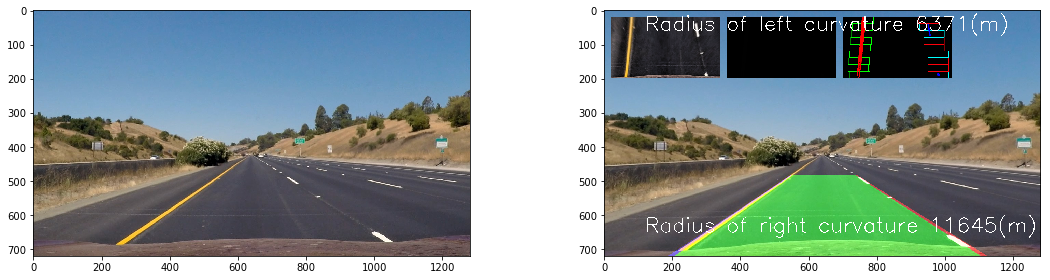

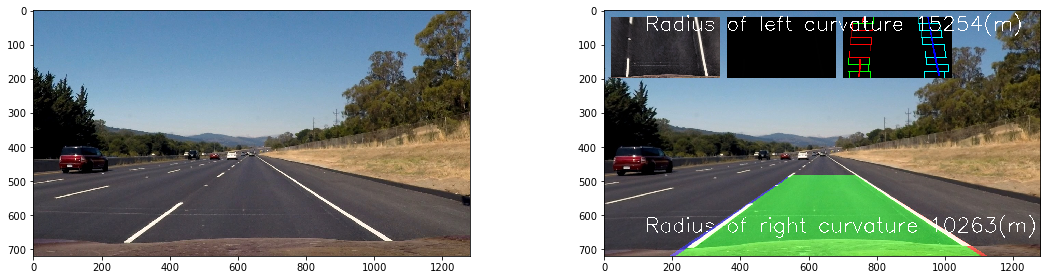

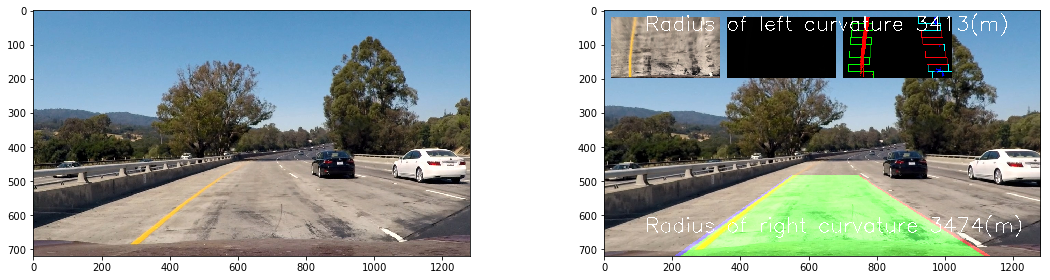

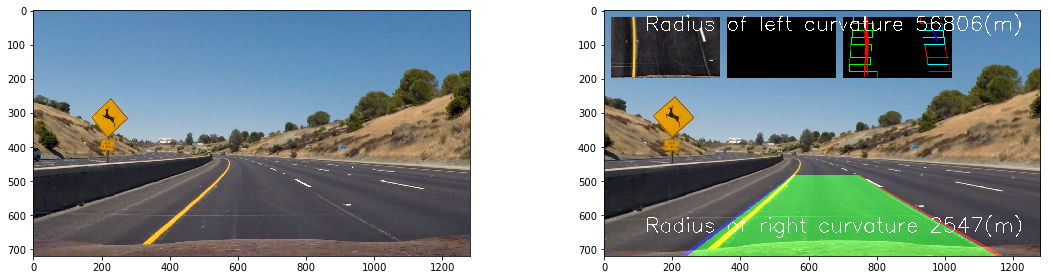

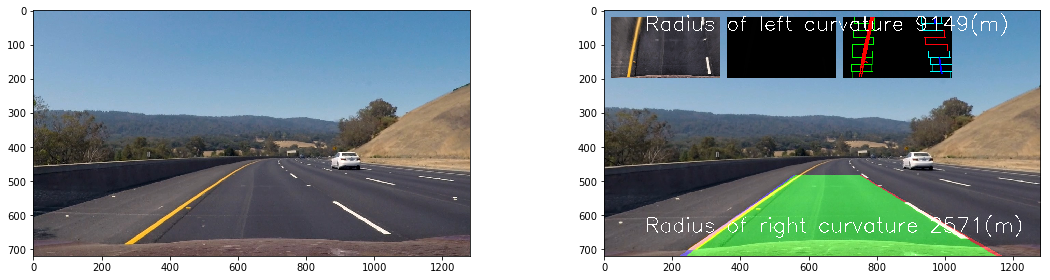

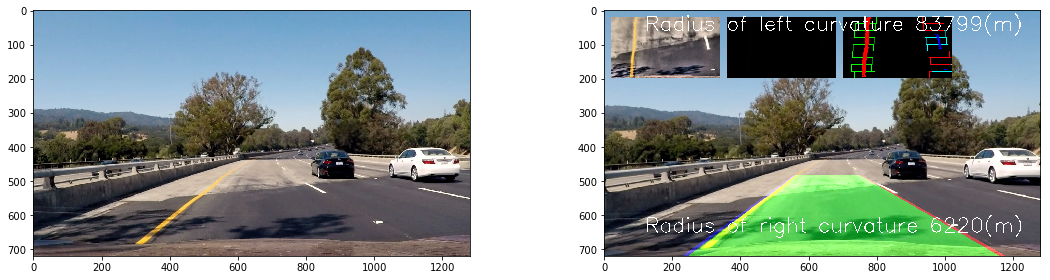

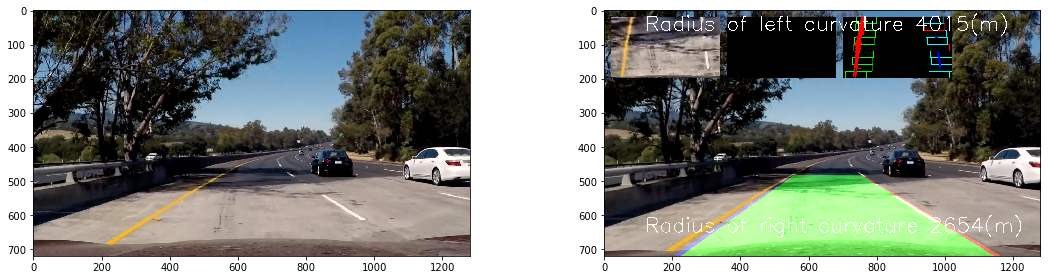

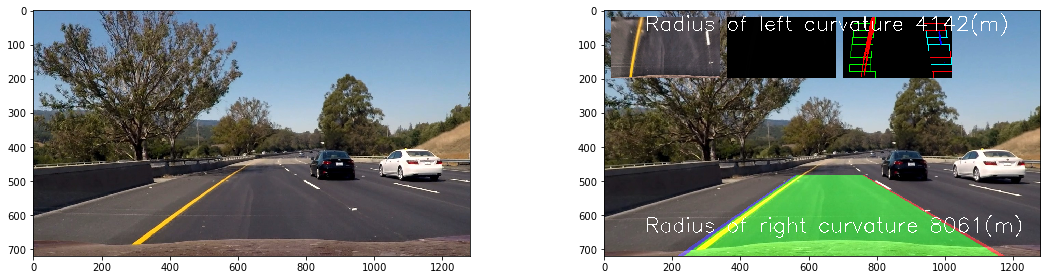

In [44]:
def sw_show2():
    images = glob.glob('./test_images/*.jpg')
    
    for fname in images:
        img = load_image(fname)
        out = pipeline(img)
        
        f = SmartFigure(1, 2, size=(16,4))
        
        f.show_color(img)
        f.show_color(out)
        
        plt.show()
        
sw_show2()

In [14]:
white_output = 'project_video_out.mp4'
lane = Lane()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
#reset()
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:45<00:00, 11.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 1min 46s


In [ ]:
white_output = 'challenge_video_out.mp4'
lane = Lane()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
#reset()
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video challenge_video_out.mp4
[MoviePy] Writing video challenge_video_out.mp4


 56%|████████████████████████████████████████████▌                                   | 270/485 [03:13<02:35,  1.38it/s]

In [16]:
white_output = 'harder_challenge_video_out.mp4'
lane = Lane()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
#reset()
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_out.mp4
[MoviePy] Writing video harder_challenge_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [01:52<00:00,  9.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_out.mp4 

Wall time: 1min 53s


In [ ]:
video_capture = cv2.VideoCapture("challenge_video.mp4")

i = 0

while True:
    # get frame by frame
    ret, frame = video_capture.read()
    
    if not ret:
        break
        
    cv2.imwrite('./challenge_video_img/' + str(i) + '.png', frame)
    i+=1

In [ ]:
import os

def sw_show4():
    images = sorted(glob.glob('./challenge_video_img/*.png'), key=os.path.getmtime)
    
    for fname in images:
        img = load_image(fname)
        out = pipeline(img)
        
        f = SmartFigure(1, 2, size=(8,6))
        
        f.show_color(img)
        f.show_color(out)
        
        plt.show()

lane = Lane()
sw_show4()

In [ ]:
import os
print(sorted(glob.glob('./harder_challenge_video_img/*.png'), key=os.path.getmtime))